# EGG-BOLD Coupling Pipeline

End-to-end gastric-brain coupling analysis using real EGG data and
synthetic BOLD phases. Demonstrates the full workflow: EGG processing,
per-volume phase extraction, voxelwise PLV mapping, and surrogate
statistical testing.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import gastropy as gp
from gastropy.neuro.fmri import (
    apply_volume_cuts,
    compute_plv_map,
    compute_surrogate_plv_map,
    create_volume_windows,
    phase_per_volume,
)

plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

## Step 1: Process EGG and Extract Per-Volume Phase

In [2]:
# Load fMRI-concurrent EGG
fmri = gp.load_fmri_egg(session="0001")
sfreq = fmri["sfreq"]
tr = fmri["tr"]

# Select best channel and get individual peak frequency
best_idx, peak_freq, _, _ = gp.select_best_channel(fmri["signal"], sfreq)
print(f"Best channel: {list(fmri['ch_names'])[best_idx]} (peak at {peak_freq:.4f} Hz = {peak_freq * 60:.2f} cpm)")

# Narrowband filter at individual peak frequency
filtered, _ = gp.apply_bandpass(
    fmri["signal"][best_idx],
    sfreq,
    low_hz=peak_freq - 0.015,
    high_hz=peak_freq + 0.015,
)
phase, analytic = gp.instantaneous_phase(filtered)

# Map to per-volume phase and trim transients
n_volumes = len(fmri["trigger_times"])
windows = create_volume_windows(fmri["trigger_times"], tr, n_volumes)
egg_vol_phase = phase_per_volume(analytic, windows)

begin_cut, end_cut = 21, 21
egg_phase = apply_volume_cuts(egg_vol_phase, begin_cut, end_cut)
print(f"EGG phase per volume: {egg_vol_phase.shape} -> trimmed: {egg_phase.shape}")

Best channel: EGG8 (peak at 0.0400 Hz = 2.40 cpm)


EGG phase per volume: (420,) -> trimmed: (378,)


## Step 2: Prepare BOLD Phases

In a real analysis, you would use `regress_confounds` and
`bold_voxelwise_phases` on NIfTI data. Here we simulate
100 voxels: 20 coupled to EGG + 80 random.

In [3]:
rng = np.random.default_rng(42)
n_trimmed = len(egg_phase)

# 20 coupled voxels with increasing noise
coupled = np.zeros((20, n_trimmed))
for i in range(20):
    offset = rng.uniform(0, 2 * np.pi)
    noise = 0.3 + 0.5 * (i / 20)
    coupled[i] = egg_phase + offset + noise * rng.standard_normal(n_trimmed)

# 80 random (uncoupled) voxels
random_phases = rng.uniform(-np.pi, np.pi, (80, n_trimmed))
bold_phases = np.vstack([coupled, random_phases])
print(f"BOLD phases: {bold_phases.shape}")

BOLD phases: (100, 378)


## Step 3: Compute PLV Map and Surrogate Testing

In [4]:
# Empirical PLV
plv_map = compute_plv_map(egg_phase, bold_phases)
print("Empirical PLV:")
print(f"  Coupled: {plv_map[:20].mean():.4f} +/- {plv_map[:20].std():.4f}")
print(f"  Random:  {plv_map[20:].mean():.4f} +/- {plv_map[20:].std():.4f}")

# Surrogate PLV
surr_map = compute_surrogate_plv_map(egg_phase, bold_phases, n_surrogates=200, seed=42)
print("\nSurrogate PLV (median):")
print(f"  Coupled: {surr_map[:20].mean():.4f}")
print(f"  Random:  {surr_map[20:].mean():.4f}")

# Z-score
z_map = gp.coupling_zscore(plv_map, surr_map)
print("\nCoupling z-score:")
print(f"  Coupled: {z_map[:20].mean():.4f} +/- {z_map[:20].std():.4f}")
print(f"  Random:  {z_map[20:].mean():.4f} +/- {z_map[20:].std():.4f}")

Empirical PLV:
  Coupled: 0.8591 +/- 0.0667
  Random:  0.0431 +/- 0.0206

Surrogate PLV (median):
  Coupled: 0.6194
  Random:  0.0437

Coupling z-score:
  Coupled: 0.2397 +/- 0.0267
  Random:  -0.0006 +/- 0.0180


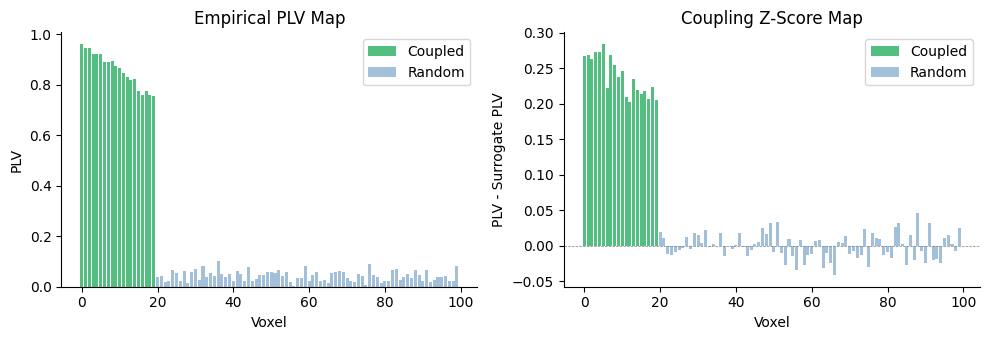

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3.5))

# PLV map
ax1.bar(range(20), plv_map[:20], color="#27AE60", alpha=0.8, label="Coupled")
ax1.bar(range(20, 100), plv_map[20:], color="steelblue", alpha=0.5, label="Random")
ax1.set_xlabel("Voxel")
ax1.set_ylabel("PLV")
ax1.set_title("Empirical PLV Map")
ax1.legend()
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)

# Z-score map
ax2.bar(range(20), z_map[:20], color="#27AE60", alpha=0.8, label="Coupled")
ax2.bar(range(20, 100), z_map[20:], color="steelblue", alpha=0.5, label="Random")
ax2.axhline(0, color="grey", linewidth=0.5, linestyle="--")
ax2.set_xlabel("Voxel")
ax2.set_ylabel("PLV - Surrogate PLV")
ax2.set_title("Coupling Z-Score Map")
ax2.legend()
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)

fig.tight_layout()
plt.show()

The coupled voxels show high empirical PLV that clearly exceeds
their surrogate baseline, yielding positive z-scores. Random voxels
cluster around zero.

**See also:** [PLV Computation](plv_computation.ipynb),
[Surrogate Testing](surrogate_testing.ipynb),
[Coupling Tutorial](../tutorials/gastric_brain_coupling.ipynb)